# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1QYd87qHd-b2vNoup-Tm0VinScJbPr0AD#scrollTo=C-PeGciqMZJo

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [4]:
# Example of a non-spam SMS
for line in open("SMSSpamCollection"):
    if line[:3] == 'ham':
        print(line)
        break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [5]:
# Example of a spam SMS
for line in open("SMSSpamCollection"):
    if line[:4] == 'spam':
        print(line)
        break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



The label value for a spam message is 'spam'. The lable value for non-spam message is 'ham'.

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [168]:
spam_num = 0
ham_num = 0

for line in open("SMSSpamCollection", encoding='utf-8'):
    if line[0] == 'h':
        ham_num += 1
    else:
        spam_num += 1
        
print('There are {} spam messages and {} non-spam messages in the data set.'.format(spam_num, ham_num))

There are 747 spam messages and 4827 non-spam messages in the data set.


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantage:**

1. The character level RNN requires less memory space than word-based RNN since the number of characters is less than the number of words. The word-based model needs more memory to store the word embeddings=, which will lead to more computational cost.

2. Character-based RNN can work on many languages with a rich morphology such as Finish, Turkish, Russian etc.


**Disadvantage:**

1. Character-based RNN will be more computationally expensive since it can grammatically correct sequences in various languages, which will require larger hidden layers, and a, while word-based RNN is faster to train.

2. It will take longer to capture long-distance dependencies using character-based RNN since it can only predict characters instead of words.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [7]:
!pip install torchtext

In [8]:
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

In [9]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

train, rest = dataset.split(split_ratio = 0.6)
valid, test = rest.split(split_ratio = 0.5)

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [10]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

The accuracy of the neural network model will be affected by the imbalanced data. The model will have trouble classifying the minority class (spam messages). Thus, having balanced data will help our model better predict the non-spam messages and improve the model accuracy.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [11]:
text_field.build_vocab(train)
text_field.vocab.stoi
#text_field.vocab.itos

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f4c94beffd0>>,
            {'\t': 101,
             '\n': 102,
             ' ': 2,
             '!': 45,
             '"': 80,
             '#': 79,
             '$': 88,
             '%': 99,
             '&': 64,
             "'": 60,
             '(': 76,
             ')': 71,
             '*': 72,
             '+': 75,
             ',': 46,
             '-': 63,
             '.': 17,
             '/': 61,
             '0': 16,
             '1': 23,
             '2': 26,
             '3': 43,
             '4': 39,
             '5': 34,
             '6': 41,
             '7': 38,
             '8': 29,
             '9': 47,
             ':': 65,
             ';': 73,
             '<': 91,
             '<pad>': 1,
             '<unk>': 0,
             '=': 82,
             '>': 81,
             '?': 59,
             '@': 84,
             'A': 37,
             'B': 55,
             'C': 33,

In [169]:
print('There are {} character tokens in the training set.'.format(len(text_field.vocab.itos)))
print('--------------------------------------------------------')
text_field.vocab.itos

There are 113 character tokens in the training set.
--------------------------------------------------------


['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 'd',
 'c',
 '0',
 '.',
 'm',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 'k',
 'T',
 '8',
 'E',
 'v',
 'S',
 'C',
 '5',
 'O',
 'I',
 'A',
 '7',
 '4',
 'N',
 '6',
 'x',
 '3',
 'R',
 '!',
 ',',
 '9',
 'P',
 'W',
 'U',
 'M',
 'H',
 'L',
 'D',
 'B',
 'F',
 'Y',
 'G',
 '?',
 "'",
 '/',
 '£',
 '-',
 '&',
 ':',
 'X',
 'z',
 'V',
 'j',
 'K',
 ')',
 '*',
 ';',
 'J',
 '+',
 '(',
 'q',
 'Q',
 '#',
 '"',
 '>',
 '=',
 'ü',
 '@',
 'Z',
 'Ü',
 '|',
 '$',
 '\x92',
 '‘',
 '<',
 '…',
 '[',
 ']',
 '\x93',
 'ú',
 '–',
 '_',
 '%',
 '~',
 '\t',
 '\n',
 '\x94',
 '’',
 '\\',
 '^',
 '\x91',
 '\x96',
 'è',
 '┾',
 '〨',
 '鈥']

Variables text_field.vocab.stoi represents a dictionary of each token string with the index of the associated vector in the vectors input argument.

Variables text_field.vocab.itos represents a list of token strings indexed by their numerical identifiers.

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

unk represents unknown tokens, which are used to replace the rare words that did not fit in our vocabulary.

pad represents the paddings added to the sequences to make sure all the sequences in our batch should have the same length.

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [13]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [178]:
n = 0
for batch in train_iter:
  length = 0
  pad_num = 0
  for i in batch.sms[0]:
    length = max(length, len(i))
    for k in i:
      if k == torch.tensor(1):
        pad_num += 1
  print('Maximum length of the input swquence in batch {} is {}.'.format((n+1), length))
  print('The number of <pad> tokens are used in batch {} is {}.'.format((n+1), pad_num))
  print('-' * 60 + "\n")
  n += 1
  if n == 10:
    break

  #print(len(batch))
  #print(batch.sms)
  #print(batch.label)

Maximum length of the input swquence in batch 1 is 39.
The number of <pad> tokens are used in batch 1 is 25.
------------------------------------------------------------

Maximum length of the input swquence in batch 2 is 131.
The number of <pad> tokens are used in batch 2 is 32.
------------------------------------------------------------

Maximum length of the input swquence in batch 3 is 22.
The number of <pad> tokens are used in batch 3 is 1.
------------------------------------------------------------

Maximum length of the input swquence in batch 4 is 75.
The number of <pad> tokens are used in batch 4 is 40.
------------------------------------------------------------

Maximum length of the input swquence in batch 5 is 35.
The number of <pad> tokens are used in batch 5 is 13.
------------------------------------------------------------

Maximum length of the input swquence in batch 6 is 157.
The number of <pad> tokens are used in batch 6 is 0.
------------------------------------

## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [15]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [281]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.name='RNN'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        encoded = self.emb[x]
        h0 = torch.zeros(1, encoded.size(0), self.hidden_size)
        out, _ = self.rnn(encoded, h0)
        return self.fc(torch.max(out, dim=1)[0])

## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [282]:
validation_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [286]:
def get_accuracy(model, train):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    if train:
        data = train_iter
    else:
        data = validation_iter
    
    correct, total = 0, 0
    for batch in data:
      inp = batch.sms[0]
      label = batch.label
      output = model(inp)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(label.view_as(pred)).sum().item()
      total += label.shape[0]
    return correct / total

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [287]:
import matplotlib.pyplot as plt

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
      i = 0
      while i <= 50:
          batch = next(iter(train_loader))
          inp = batch.sms[0]
          label = batch.label
          pred = model(inp)
          loss = criterion(pred, label)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          i += 1
            
      losses.append(float(loss))
      epochs.append(epoch)
          
      train_acc.append(get_accuracy(model, train=True))
      valid_acc.append(get_accuracy(model, train=False))
      print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.671183; Train Acc 0.942996; Val Acc 0.973070
Epoch 2; Loss 0.652392; Train Acc 0.926518; Val Acc 0.919210
Epoch 3; Loss 0.567715; Train Acc 0.929881; Val Acc 0.967684
Epoch 4; Loss 0.143671; Train Acc 0.945182; Val Acc 0.966786
Epoch 5; Loss 0.072736; Train Acc 0.948714; Val Acc 0.962298
Epoch 6; Loss 0.174505; Train Acc 0.955944; Val Acc 0.967684
Epoch 7; Loss 0.177505; Train Acc 0.954095; Val Acc 0.969479
Epoch 8; Loss 0.073926; Train Acc 0.959644; Val Acc 0.967684
Epoch 9; Loss 0.356964; Train Acc 0.937279; Val Acc 0.975763
Epoch 10; Loss 0.180521; Train Acc 0.962334; Val Acc 0.973070


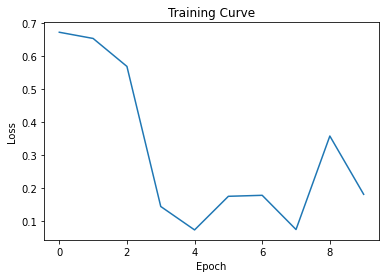

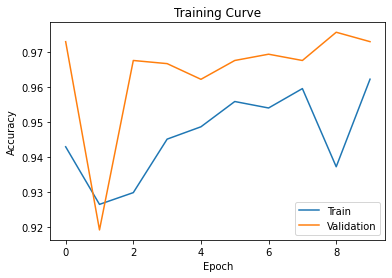

In [288]:
model = RNN(160, 100, 2)
train_acc = train_network(model, train_iter, validation_iter, num_epochs=10, learning_rate=0.0005)

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The hyperparameters I choose to tune are learning rate, number of epoch, hidden_size, and the model structure.

Epoch 1; Loss 0.504086; Train Acc 0.489154; Val Acc 0.858169
Epoch 2; Loss 0.416012; Train Acc 0.892215; Val Acc 0.958707
Epoch 3; Loss 0.386605; Train Acc 0.938625; Val Acc 0.974865
Epoch 4; Loss 0.164282; Train Acc 0.949050; Val Acc 0.952424
Epoch 5; Loss 0.256063; Train Acc 0.944846; Val Acc 0.974865
Epoch 6; Loss 0.117246; Train Acc 0.955103; Val Acc 0.964093
Epoch 7; Loss 0.619968; Train Acc 0.957458; Val Acc 0.972172
Epoch 8; Loss 0.023866; Train Acc 0.958130; Val Acc 0.973968
Epoch 9; Loss 0.087072; Train Acc 0.963511; Val Acc 0.966786
Epoch 10; Loss 0.138214; Train Acc 0.963175; Val Acc 0.963196
Epoch 11; Loss 0.164575; Train Acc 0.961157; Val Acc 0.952424
Epoch 12; Loss 0.059979; Train Acc 0.949554; Val Acc 0.929982
Epoch 13; Loss 0.037017; Train Acc 0.967042; Val Acc 0.970377
Epoch 14; Loss 0.877451; Train Acc 0.968556; Val Acc 0.970377
Epoch 15; Loss 0.067804; Train Acc 0.969228; Val Acc 0.963196
Epoch 16; Loss 0.094024; Train Acc 0.970237; Val Acc 0.964991
Epoch 17; Loss 0.

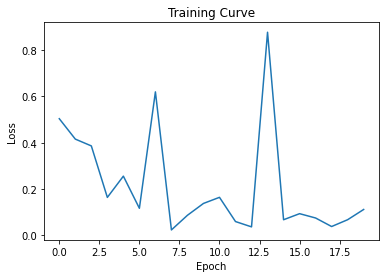

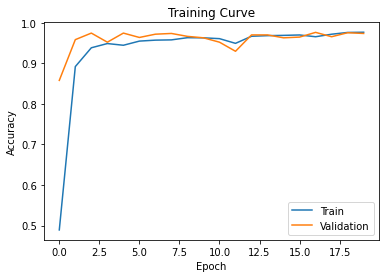

In [22]:
model = RNN(160, 100, 2)
train_network(model, train_iter, validation_iter, num_epochs = 20, learning_rate = 0.0005)

Epoch 1; Loss 0.454094; Train Acc 0.675803; Val Acc 0.418312
Epoch 2; Loss 0.552793; Train Acc 0.944846; Val Acc 0.957810
Epoch 3; Loss 0.576691; Train Acc 0.940138; Val Acc 0.973070
Epoch 4; Loss 0.393115; Train Acc 0.956280; Val Acc 0.958707
Epoch 5; Loss 0.112210; Train Acc 0.945014; Val Acc 0.974865
Epoch 6; Loss 0.067337; Train Acc 0.953422; Val Acc 0.972172
Epoch 7; Loss 0.179050; Train Acc 0.956953; Val Acc 0.956014
Epoch 8; Loss 0.053243; Train Acc 0.958803; Val Acc 0.975763
Epoch 9; Loss 0.281416; Train Acc 0.964184; Val Acc 0.965889
Epoch 10; Loss 0.228866; Train Acc 0.948545; Val Acc 0.974865


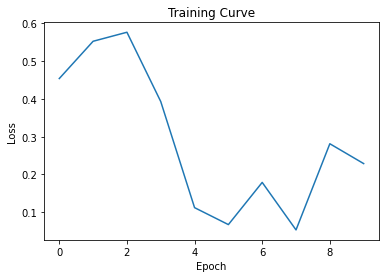

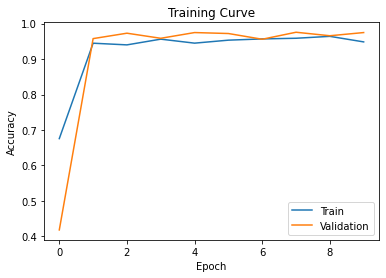

In [23]:
model = RNN(160, 100, 2)
train_network(model, train_iter, validation_iter, num_epochs = 10, learning_rate = 0.001)

Epoch 1; Loss 0.627160; Train Acc 0.669077; Val Acc 0.441652
Epoch 2; Loss 0.615664; Train Acc 0.908357; Val Acc 0.963196
Epoch 3; Loss 0.374568; Train Acc 0.928367; Val Acc 0.918312
Epoch 4; Loss 0.397877; Train Acc 0.937952; Val Acc 0.962298
Epoch 5; Loss 0.383524; Train Acc 0.944342; Val Acc 0.957810
Epoch 6; Loss 0.217215; Train Acc 0.926518; Val Acc 0.963196
Epoch 7; Loss 0.352714; Train Acc 0.953590; Val Acc 0.956912
Epoch 8; Loss 0.084280; Train Acc 0.950731; Val Acc 0.962298
Epoch 9; Loss 0.126392; Train Acc 0.952413; Val Acc 0.935368
Epoch 10; Loss 0.210618; Train Acc 0.951236; Val Acc 0.929084


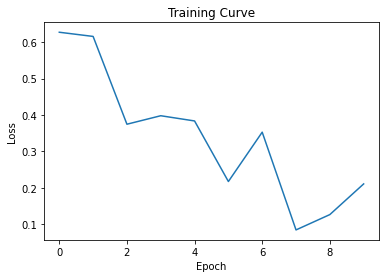

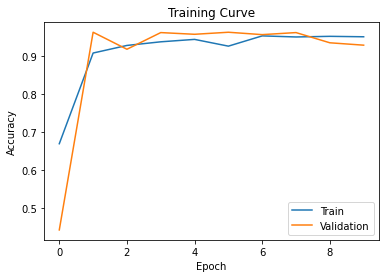

In [24]:
model = RNN(160, 64, 2)
train_network(model, train_iter, validation_iter, num_epochs = 10, learning_rate = 0.0005)

In [184]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.name='GRU'
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        encoded = self.emb[x]
        h0 = torch.zeros(1, encoded.size(0), self.hidden_size)
        out, _ = self.rnn(encoded, h0)
        return self.fc(torch.max(out, dim=1)[0])

Epoch 1; Loss 0.601822; Train Acc 0.510846; Val Acc 0.141831
Epoch 2; Loss 0.704326; Train Acc 0.527829; Val Acc 0.171454
Epoch 3; Loss 0.534212; Train Acc 0.941147; Val Acc 0.947935
Epoch 4; Loss 0.440378; Train Acc 0.851858; Val Acc 0.961400
Epoch 5; Loss 0.145560; Train Acc 0.924500; Val Acc 0.972172
Epoch 6; Loss 0.279429; Train Acc 0.938961; Val Acc 0.965889
Epoch 7; Loss 0.401674; Train Acc 0.933412; Val Acc 0.972172
Epoch 8; Loss 0.052465; Train Acc 0.943669; Val Acc 0.973070
Epoch 9; Loss 0.016042; Train Acc 0.944846; Val Acc 0.977558
Epoch 10; Loss 0.097610; Train Acc 0.937784; Val Acc 0.978456
Epoch 11; Loss 0.037868; Train Acc 0.938288; Val Acc 0.976661
Epoch 12; Loss 0.063519; Train Acc 0.948209; Val Acc 0.976661
Epoch 13; Loss 0.054519; Train Acc 0.951740; Val Acc 0.973070
Epoch 14; Loss 0.151508; Train Acc 0.952077; Val Acc 0.975763
Epoch 15; Loss 0.040853; Train Acc 0.953422; Val Acc 0.975763
Epoch 16; Loss 0.280051; Train Acc 0.959307; Val Acc 0.975763
Epoch 17; Loss 0.

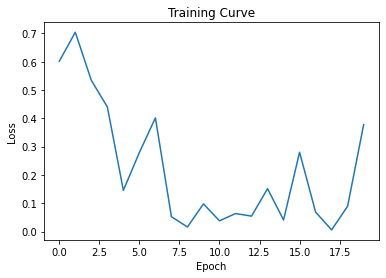

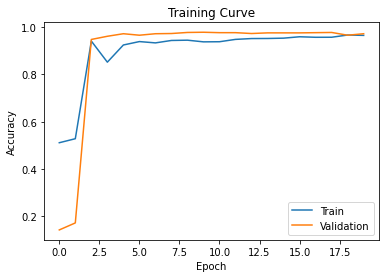

In [321]:
model = GRU(160, 100, 2)
train_network(model, train_iter, validation_iter, num_epochs = 20, learning_rate = 0.0005)

I tuned the hyperparameter by increasing the learning rate, increasing the number of epochs and decreasing the hidden size. The loss increases, and accuracy decreases when we decrease the hidden size. The results of changing number of epochs seem similar. Based on the results, I changed the model structure from CNN to GRU with learning rate = 0.0005 and epoch_num = 20, the accuracy increases a little and the loss decreases. I chose these hyperparameters because learning rate and epoch are presented as the two most important parameters to tune for a neural network model. They can impact the training time and process. Also, the hidden size and model structure can affect the accuracy and affect the performance of the model. The best validation accuracy is around 0.979 by the 10th epoch of the GRU model with learning rate = 0.0005, hidden size = 100.

### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

The model I chose here is the GRU model with learning rate = 0.0005 and epoch_num = 20, which was the last model I trained.

In [188]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [189]:
valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=len(valid_spam),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=len(valid_nospam),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [192]:
def get_accuracy_2(model,loader):
    correct, total = 0, 0
    for batch in loader:
        inp = batch.sms[0]
        label = batch.label
        output = model(inp)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += label.shape[0]
    return correct / total

print('The false positive rate for the final model across the spam validation set is {:.3f}.'.format(1 - get_accuracy_2(model, valid_spam_iter)))
print('-' * 90)
print('The false negative rate for the final model across the non-spam validation set is {:.3f}.'.format(1 - get_accuracy_2(model, valid_nospam_iter)))

The false positive rate for the final model across the spam validation set is 0.101.
------------------------------------------------------------------------------------------
The false negative rate for the final model across the non-spam validation set is 0.014.


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive is a ham message that has been incorrectly identified as spam, whereas a false negative is a spam message that has been incorrectly identified as ham.

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [191]:
print('The final test accuracy of the final model is {:.3f}.'.format(get_accuracy_2(model, test_iter)))

The final test accuracy of the final model is 0.972.


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [193]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=len(test_spam),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=len(test_nospam),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print('The false positive rate for the final model aross the spam validation set is {:.3f}.'.format(1 - get_accuracy_2(model, test_spam_iter)))
print('-' * 90)
print('The false negative rate for the final model aross the non-spam validation set is {:.3f}.'.format(1 - get_accuracy_2(model, test_nospam_iter)))

The false positive rate for the final model aross the spam validation set is 0.090.
------------------------------------------------------------------------------------------
The false negative rate for the final model aross the non-spam validation set is 0.017.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [297]:
msg = "machine learning is sooo cool!"

# The tensor format of indexs of each character in the vocabulary.
msg_tensor = torch.tensor([[text_field.vocab.stoi[x] for x in msg]])
msg_tensor

tensor([[18,  6, 15, 13,  9,  7,  3,  2, 11,  3,  6,  8,  7,  9,  7, 22,  2,  9,
         10,  2, 10,  4,  4,  4,  2, 15,  4,  4, 11, 45]])

In [322]:
from scipy.special import softmax
print('The probability that the message is spam is {:.3f}'.format(softmax((model(msg_tensor)[0]).detach().numpy())[1]))

The probability that the message is spam is 0.056


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Based on the results and accuracy, detecting spam is easy using our model.

We can also use the baseline model: Naive Bayes classification to detect spam messages.

To build the Naive Bayes classification model, we need to manually indicate whether the message in the training set is spam or not. Then, compute each word's probability that appears in the spam and non-spam messages. After doing this, the model is trained. We will have the word probabilities used to compute the probability of a message with a set of words in each category. Each word in the training set will contribute to the spam probability, calculated using the Bayes theorem. Then, we will get the spam probability for all words in the training data, and we can set a threshold to classify the spam messages.

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [90]:
# install relevant libraries
!pip install fastai

In [91]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [92]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-03-23 19:48:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.08s   

2022-03-23 19:48:14 (2.32 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [93]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [94]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [95]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [96]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [97]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [98]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the players move into use but later work in a
The problem usually starts when a to hold a point of being where time is
The problem usually starts when the character is in the little room , in which
The problem usually starts when a US citizen or American Town
The problem usually starts when in New Other Year , the dance


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

In [167]:
for i in range(5):
  print(lang_mod.predict("My medical leave was approved", n_words=10))

My medical leave was approved for 29 / 03 ! xxbos Ok .
My medical leave was approved only . Already , late morning on Tuesday
My medical leave was approved , so my dad called for bath . xxbos
My medical leave was approved 4 Expires 26 / 25 w Am seeing
My medical leave was approved , pay allah < # > dollars . 16+only


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [100]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.560389,3.864957,0.257143,00:01
1,4.834316,3.861084,0.257143,00:01
2,4.386715,3.813980,0.314286,00:01
3,4.062469,3.808453,0.300000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.592429,3.808745,0.300000,00:01
1,3.541257,3.752309,0.300000,00:01
2,3.478170,3.744909,0.285714,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.400074,3.756283,0.314286,00:01
1,3.387759,3.742145,0.285714,00:01
2,3.365225,3.756291,0.257143,00:01


epoch,train_loss,valid_loss,accuracy,time
0,3.341396,3.776521,0.257143,00:02
1,3.301505,3.753174,0.257143,00:02
2,3.265203,3.751842,0.257143,00:02


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [101]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [102]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos xxmaj sad story of a xxmaj man - xxmaj last week was my b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n so did my xxmaj kids . i went to work . xxmaj even my xxmaj colleagues did not wish . xxmaj as i entered my cabin my xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! !",ham
xxbos xxmaj how to xxmaj make a girl xxmaj happy ? xxmaj it 's not at all difficult to make girls happy . u only need to be ... 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good boyfriend < #,ham
"xxbos xxmaj indians r poor but xxmaj india is not a poor country . xxmaj says one of the swiss bank xxunk . xxmaj he says that "" < # > xxunk crore "" of xxmaj indian money is xxunk in swiss banks which can be used for ' xxunk ' budget for < # > yrs . xxmaj can give < # > crore xxunk to all xxmaj indians",ham
"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" xxup hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" xxmaj margaret xxmaj hello "" xxmaj she is",ham


In [104]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [105]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-01
Min loss divided by 10: 5.25E-02


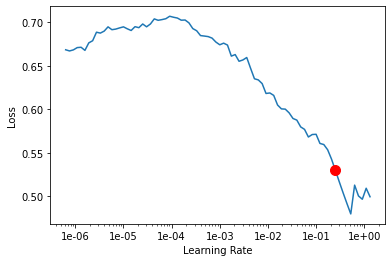

In [106]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [107]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.377644,0.080735,0.980861,00:03
1,0.182157,0.086004,0.981459,00:03
2,0.125010,0.083251,0.982057,00:03
3,0.094485,0.083865,0.983254,00:02
4,0.091109,0.081221,0.985048,00:02


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

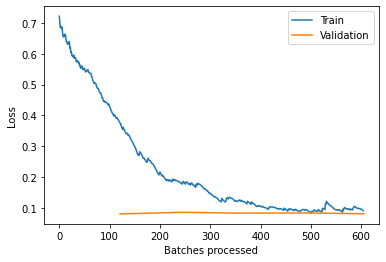

In [108]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.32E-07


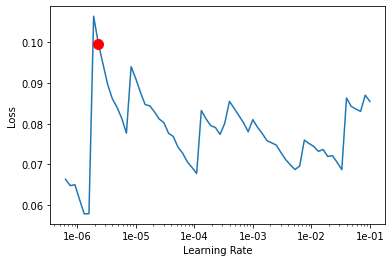

In [109]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [110]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([1.0000e+00, 3.2068e-06]))

In [111]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(0), tensor(0), tensor([0.7474, 0.2526]))

Next we will evaluate on all of our validation data.

In [215]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

The best accuracy obtained with ULMFiT is 0.985048, which is much higher than the approach in the first part using only LSTM.

### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [115]:
from sklearn.metrics import confusion_matrix
# Taken from the scikit-learn documentation
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

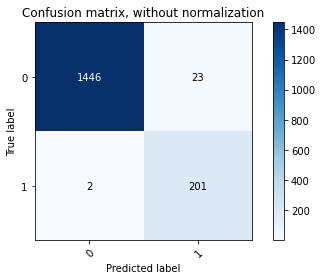

In [116]:
# Plot the confusion matrix using ULMFiT
plot_confusion_matrix(valid_preds.max(1, keepdim=True)[1], valid_label, classes = [0,1])
plt.show()

In [246]:
print('Accuracy for ULMFiT with validation data: {}.'.format((1446+201)/(1446+23+2+201)))

Accuracy for ULMFiT with validation data: 0.9850478468899522.


In [164]:
# Using the data and model from PartA
validation_iter = torchtext.legacy.data.BucketIterator(valid,
                                           batch_size=len(valid),
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)     
for batch in validation_iter:
    inp = batch.sms[0]
    label = batch.label
    output = model(inp)
    pred=output.max(1, keepdim=True)[1]

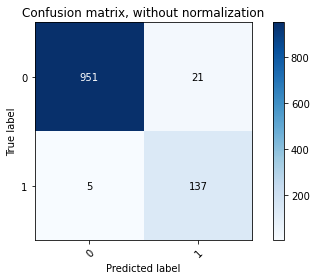

In [165]:
plot_confusion_matrix(pred,label,classes = [0,1])

In [247]:
print('Accuracy for GRU with validation data: {}.'.format((951+137)/(951+137+21+5)))

Accuracy for GRU with validation data: 0.9766606822262118.


## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [121]:
learn_classifier.predict("machine learning is sooo cool!")

(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.5959e-14]))

The model predict the probability that this SMS message is spam is 1.5959e-14, which is very close to 0.

### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

##### Example 1

In [357]:
learn_classifier.predict("Only 4 days left to apply for NEST")

(Category tensor(1), tensor(1), tensor([0.2796, 0.7204]))

In [358]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "Only 4 days left to apply for NEST"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is spam is {:.3f}.'.format(prob[1]))

The probability this message using the model in Part A is spam is 0.131.


##### Example 2

In [359]:
learn_classifier.predict("SURPRISE! Weekly mysterious box is waiting for you! Get your luck NOW!")

(Category tensor(1), tensor(1), tensor([0.3242, 0.6758]))

In [360]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "SURPRISE! Weekly mysterious box is waiting for you! Get your luck NOW!"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is spam is {:.3f}.'.format(prob[1]))

The probability this message using the model in Part A is spam is 0.153.


##### Example 3

In [361]:
learn_classifier.predict("We're BACK UP and running! 20% OFF at Stylevana")

(Category tensor(0), tensor(0), tensor([0.8126, 0.1874]))

In [362]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "We're BACK UP and running! 20% OFF at Stylevana"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is spam is {:.3f}.'.format(prob[1]))

The probability this message using the model in Part A is spam is 0.893.


##### Example 4

In [369]:
learn_classifier.predict("Get the App — Enjoy 25% OFF")

(Category tensor(1), tensor(1), tensor([0.4476, 0.5524]))

In [370]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "Get the App — Enjoy 25% OFF"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is spam is {:.3f}.'.format(prob[1]))

The probability this message using the model in Part A is spam is 0.291.


##### Example 5

In [371]:
learn_classifier.predict("Your 30% OFF Private Sale Invitation")

(Category tensor(1), tensor(1), tensor([0.2390, 0.7610]))

In [372]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "Your 30% OFF Private Sale Invitation"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is spam is {:.3f}.'.format(prob[1]))

The probability this message using the model in Part A is spam is 0.647.


The two models' performances are different for most examples. The ULMFiT model seems to have a better prediction for most cases.

### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

##### Example 1

In [323]:
learn_classifier.predict("'Characterization of mobility patterns and collective behavior through the analytical processing of real-world complex networks' by Jose F Rodrigues-Jr")

(Category tensor(0), tensor(0), tensor([0.8153, 0.1847]))

In [324]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "'Characterization of mobility patterns and collective behavior through the analytical processing of real-world complex networks' by Jose F Rodrigues-Jr"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is non-spam is {:.3f}.'.format(prob[0]))

The probability this message using the model in Part A is non-spam is 0.796.


##### Example 2

In [325]:
learn_classifier.predict("Your order from Beautylish - PZXK-DQXJ")

(Category tensor(0), tensor(0), tensor([0.9157, 0.0843]))

In [326]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "Your order from Beautylish - PZXK-DQXJ"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is non-spam is {:.3f}.'.format(prob[0]))

The probability this message using the model in Part A is non-spam is 0.575.


##### Example 3

In [327]:
learn_classifier.predict("GECoS Newsletter Updated Links")

(Category tensor(0), tensor(0), tensor([1.0000e+00, 6.7273e-07]))

In [328]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "GECoS Newsletter Updated Links"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is non-spam is {:.3f}.'.format(prob[0]))

The probability this message using the model in Part A is non-spam is 0.873.


##### Example 4

In [329]:
learn_classifier.predict("You look like a good fit for the job at University of Toronto. Apply now.")

(Category tensor(0), tensor(0), tensor([0.9410, 0.0590]))

In [330]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "You look like a good fit for the job at University of Toronto. Apply now."]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is non-spam is {:.3f}.'.format(prob[0]))

The probability this message using the model in Part A is non-spam is 0.925.


##### Example 5

In [331]:
learn_classifier.predict("'Computational Network Analysis; Statistics & Topologies of German Cities Masters of Engineering Geodesy and Geoinformatics' by Rugilandavyi Mubondo")

(Category tensor(0), tensor(0), tensor([0.7925, 0.2075]))

In [332]:
prob = softmax((model(torch.tensor([[text_field.vocab.stoi[x] for x in "'Computational Network Analysis; Statistics & Topologies of German Cities Masters of Engineering Geodesy and Geoinformatics' by Rugilandavyi Mubondo"]]))[0]).detach().numpy())
print('The probability this message using the model in Part A is non-spam is {:.3f}.'.format(prob[0]))

The probability this message using the model in Part A is non-spam is 0.926.


The two models both detect all the non-spam messages. Even though the performances for detecting spam are different, the predictions on non-spam messages are good. This may be due to the imbalanced data in the first place. The information that spam messages provided in the training data set are limited although we fixed the disparity by duplicating spam messages in the training set.

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook TUT_4B_Generative_RNN.ipynb to html
[NbConvertApp] Writing 602750 bytes to TUT_4B_Generative_RNN.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus